## ----------------------------------Fine Tuning---------------------------------------- ##

In [1]:
import torch
import torch.nn as nn

# Define the Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64 * 64 * 3),  # Assuming RGB image of size 64x64
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 3, 64, 64)  # Reshape to image dimensions
        return x

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(64 * 64 * 3, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability of being real/fake
        )

    def forward(self, x):
        x = x.view(-1, 64 * 64 * 3)  # Flatten the image
        x = self.model(x)
        return x


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')
# Define transformations for your dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Load your dataset (remove extra double quotes around path)
image_directory = r"C:/Users/Srinivasa Rao/OneDrive/Documents/GUVI Files/Datasets/raw-img"

# 'ImageFolder' assumes that each subfolder in 'raw-img' represents a different class
dataset = datasets.ImageFolder(root=image_directory, transform=transform)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Print the class names (i.e., subfolder names)
print(f"Classes found: {dataset.classes}")


Classes found: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [4]:
import torch
import torch.optim as optim
import torch.nn as nn

# Check if a GPU is available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
latent_dim = 100
epochs = 100
lr = 0.0002 #learning rate

# Initialize models and move them to GPU
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss().to(device)
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training loop
for epoch in range(epochs):
    for real_images, _ in dataloader:
        batch_size = real_images.size(0)
        
        # Move real images to GPU
        real_images = real_images.to(device)
        
        # Labels for real and fake images (also move to GPU)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # -------------------
        # Train the Discriminator
        # -------------------
        # Real images
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)

        # Fake images
        noise = torch.randn(batch_size, latent_dim).to(device)  # Move noise to GPU
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())  # Detach to avoid updating generator during D training
        d_loss_fake = criterion(outputs, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()
        
        # -------------------
        # Train the Generator
        # -------------------
        # Generator wants to trick the discriminator
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()
    
    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")
    
    # Optionally, save generated images periodically
    # generate_and_save_images(generator, epoch + 1)  # Use your function for saving images
 

Epoch [1/100], D Loss: 0.16362592577934265, G Loss: 3.0565414428710938
Epoch [2/100], D Loss: 0.1702820509672165, G Loss: 4.304598808288574
Epoch [3/100], D Loss: 0.16596120595932007, G Loss: 2.618121862411499
Epoch [4/100], D Loss: 0.6165757179260254, G Loss: 4.239109992980957
Epoch [5/100], D Loss: 0.41730767488479614, G Loss: 3.1316611766815186
Epoch [6/100], D Loss: 0.13725337386131287, G Loss: 3.9696474075317383
Epoch [7/100], D Loss: 0.9324644804000854, G Loss: 4.8806681632995605
Epoch [8/100], D Loss: 0.5022804737091064, G Loss: 6.463847637176514
Epoch [9/100], D Loss: 0.591968297958374, G Loss: 8.057540893554688
Epoch [10/100], D Loss: 0.11080898344516754, G Loss: 4.8018059730529785
Epoch [11/100], D Loss: 0.27771440148353577, G Loss: 3.7492878437042236
Epoch [12/100], D Loss: 0.15609073638916016, G Loss: 4.238486289978027
Epoch [13/100], D Loss: 0.4391079843044281, G Loss: 4.132699966430664
Epoch [14/100], D Loss: 0.19387786090373993, G Loss: 3.9498679637908936
Epoch [15/100],

In [5]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


## ------------------ Image Generation From Finetuned Model ------------------- ##

In [6]:
import torch
import torchvision.utils as vutils
import numpy as np
from PIL import Image
import os


In [7]:
class Generator(torch.nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = torch.nn.Sequential(
            # Define the architecture of your generator here
            torch.nn.Linear(latent_dim, 256),
            torch.nn.ReLU(True),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(True),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(1024, 64*64*3),  # For generating 64x64 RGB images
            torch.nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 64, 64)  # Reshape for 3 channels (RGB)
        return img


In [9]:
latent_dim = 100  # Make sure this matches the latent_dim used during training

# Initialize the generator model
generator = Generator(latent_dim)

# Load the fine-tuned weights
generator.load_state_dict(torch.load('generator.pth'))

# Move the generator model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)

# Set the model to evaluation mode
generator.eval()


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=1024, out_features=12288, bias=True)
    (7): Tanh()
  )
)

In [10]:
# Generate random noise (latent vectors)
batch_size = 16  # Number of images to generate
noise = torch.randn(batch_size, latent_dim).to(device)  # Random noise


In [11]:
# Generate images using the generator
with torch.no_grad():  # No need to calculate gradients during inference
    generated_images = generator(noise)

# Denormalize the images from [-1, 1] to [0, 1] (for visualization purposes)
generated_images = (generated_images + 1) / 2


In [12]:
# Create a grid of generated images
grid = vutils.make_grid(generated_images, nrow=4, normalize=True)

# Convert the grid to a numpy array and save as an image
ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).byte().permute(1, 2, 0).cpu().numpy()
img = Image.fromarray(ndarr)
img.save('generated_images_grid.png')


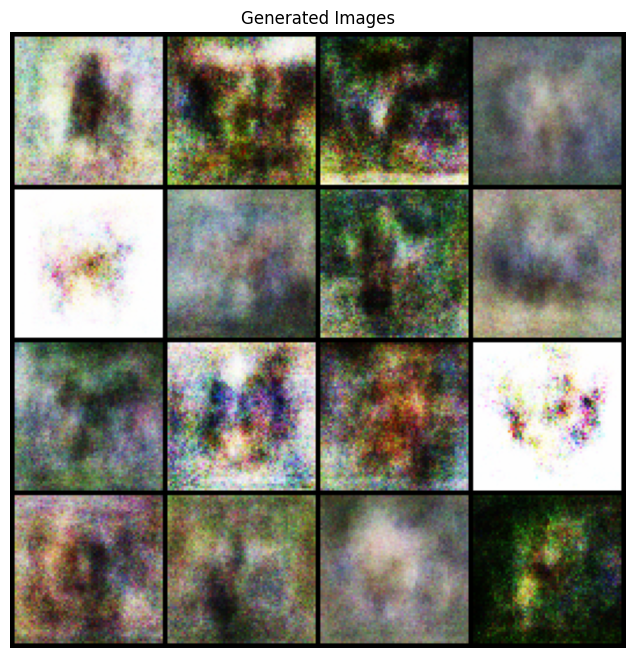

In [13]:
import matplotlib.pyplot as plt

# Show the generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generated_images, nrow=4, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()
